# ArcFace Loss (Additive Angular Margin Loss)

## Теория ArcFace

В случае с обучением на задачу классификации первая подходящая лосс-функция, которая нам приходит в голову — Cross-Entropy. И на ней действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

## Другие лоссы

Кроме ArcFace, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте в качестве дополнительного задания.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего. Целиком брать весь датасет CelebA не обязательно, он слишком большой.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/1sjO2-N8EsLb2HQcOELikFQCqKUWrPehJ?usp=sharing).

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

In [ ]:
import os
import math
from torch.optim import lr_scheduler
from tqdm import tqdm
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Subset
import random

- Данные - выровненные лица 500 людей из датасета CelebA-500.
  - `celebA_imgs` — папка с выровненными картинками;
  - `celebA_anno.txt` — файл с аннотацией — каждой картинке из `celebA_imgs` поставлен в соответствие ее id;
  - `celebA_train_split.txt` — файл со сплитом на train/val/test.


### Этап 1: Подготовка таблицы с информацией о изображениях (images_info)

  - Загрузка и объединение аннотаций (celebrities IDs) и разметки (splits train/val/test) для датасета CelebA-500

In [ ]:
# Подготовка данных

# --- 1. Указываем пути к данным ---
images_dir = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_imgs'
annotations_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_anno.txt'
split_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_train_split.txt'

# --- 2. Читаем аннотации (сопоставление изображения и id) ---
# Файл имеет две колонки: имя картинки и её ID
annotations = pd.read_csv(annotations_file, sep='\s+', header=None, names=["img_name", "image_id"])

# --- 3. Читаем файл с разбиением на train/val/test ---
with open(split_file, 'r') as f:
    split_lines = f.read().splitlines()

# Каждая строка имеет вид: 'имя_картинки 0/1/2'
# Преобразуем строки в DataFrame
split_data = [line.strip().split() for line in split_lines]
splits = pd.DataFrame(split_data, columns=["img_name", "segment"])

# Заменим числовые метки на понятные категории
splits["segment"] = splits["segment"].replace({"0": "train", "1": "val", "2": "test"})

# --- 4. Объединяем аннотации и разметку по имени изображения ---
# Оставляем только те строки, которые есть и в splits, и в annotations
images_info = pd.merge(splits, annotations, on="img_name", how="left")

# Проверим, всё ли объединилось корректно
print(f"\nОбъединённый датафрейм: {images_info.shape[0]} строк, {images_info.shape[1]} столбца")
display(images_info.head())

# --- 5. Проверим распределение по сегментам ---
print("\nРаспределение по сегментам:")
display(images_info["segment"].value_counts())


Объединённый датафрейм: 12011 строк, 3 столбца


,img_name,segment,image_id
0,000001.jpg,train,0
1,000404.jpg,train,0
2,003415.jpg,train,0
3,004390.jpg,train,0
4,018062.jpg,train,0



Распределение по сегментам:


segment
train    8544
val      1878
test     1589
Name: count, dtype: int64

### Этап 2: Датасет

In [ ]:
# Датасет

class CelebADataset(Dataset):
    def __init__(self, images_info, images_dir, mode):
        super().__init__()
        self.mode = mode
        self.images_dir = images_dir
        self.images_info = images_info[images_info.segment == mode]

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):

        # берем картинку
        img_name = os.path.join(self.images_dir, self.images_info.iloc[idx]['img_name'])
        image = np.array(Image.open(img_name))

        # кроп
        image = Image.fromarray(image[77:-41, 45:-50])

        # метка
        label = self.images_info.iloc[idx]['image_id'] 

        # аугментации
        rescale_size=256
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((rescale_size, rescale_size)),
                transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
                transforms.RandomResizedCrop(rescale_size, scale=(0.9, 1.0)),  # Random crop with slight zoom-in effect
                transforms.ToTensor(),
                # в соответствии со значениями среднего и стандартного отклонения для моделей, обученных на ImageNet
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((rescale_size, rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        image = transform(image)
        return image, label

### Этап 3: Загрузка данных

In [ ]:
# Подготовка функции потерь и оптимизатора

# Создание объектов Dataset
train_dataset = CelebADataset(images_info, images_dir, mode="train")
val_dataset = CelebADataset(images_info, images_dir, mode="val")
test_dataset = CelebADataset(images_info, images_dir, mode="test")

# Берем val_size = 20%
val_size = len(val_dataset)
subset_size = math.ceil(val_size * 0.2)

# Создаем подмножество 20%
val_subset = Subset(val_dataset, list(range(subset_size)))

### Этап 4: Обучение модели с лосс - CrossEntropy

In [ ]:
# EfficientNet_B1_Weights - CrossEntropy loss

# Количество классов
num_classes = 500
num_epochs = 10

# Перемещаем модель на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Заменяем классификатор (голову) на новый с нужным числом выходов
weights = EfficientNet_B1_Weights.IMAGENET1K_V2
model = efficientnet_b1(weights=weights)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(100 * correct / total)

    print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Оценка на валидации
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")
    scheduler.step()  # Передаем avg_val_loss, если используешь ReduceLROnPlateau


Epoch 1/10: 100%|███████████████████████████████████████████████████| 67/67 [01:20<00:00,  1.21s/it]


Train Loss: 5.1399, Accuracy: 8.45%
Validation Loss: 3.7293, Validation Accuracy: 19.70%


Epoch 2/10: 100%|███████████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Train Loss: 2.5551, Accuracy: 43.59%
Validation Loss: 2.3147, Validation Accuracy: 47.34%


Epoch 3/10: 100%|███████████████████████████████████████████████████| 67/67 [01:34<00:00,  1.40s/it]


Train Loss: 1.2142, Accuracy: 73.03%
Validation Loss: 1.8726, Validation Accuracy: 55.43%


Epoch 4/10: 100%|███████████████████████████████████████████████████| 67/67 [01:28<00:00,  1.33s/it]


Train Loss: 0.4660, Accuracy: 92.60%
Validation Loss: 1.4238, Validation Accuracy: 67.04%


Epoch 5/10: 100%|███████████████████████████████████████████████████| 67/67 [01:28<00:00,  1.32s/it]


Train Loss: 0.2875, Accuracy: 96.79%
Validation Loss: 1.3955, Validation Accuracy: 68.16%


Epoch 6/10: 100%|███████████████████████████████████████████████████| 67/67 [01:19<00:00,  1.18s/it]


Train Loss: 0.2138, Accuracy: 98.28%
Validation Loss: 1.3654, Validation Accuracy: 68.00%


Epoch 7/10: 100%|███████████████████████████████████████████████████| 67/67 [01:19<00:00,  1.19s/it]


Train Loss: 0.1600, Accuracy: 98.95%
Validation Loss: 1.3573, Validation Accuracy: 68.42%


Epoch 8/10: 100%|███████████████████████████████████████████████████| 67/67 [01:20<00:00,  1.21s/it]


Train Loss: 0.1538, Accuracy: 99.13%
Validation Loss: 1.3514, Validation Accuracy: 68.64%


Epoch 9/10: 100%|███████████████████████████████████████████████████| 67/67 [01:23<00:00,  1.24s/it]


Train Loss: 0.1431, Accuracy: 99.37%
Validation Loss: 1.3509, Validation Accuracy: 68.58%


Epoch 10/10: 100%|██████████████████████████████████████████████████| 67/67 [01:19<00:00,  1.18s/it]


Train Loss: 0.1348, Accuracy: 99.27%
Validation Loss: 1.3479, Validation Accuracy: 68.74%


In [ ]:
# Accuracy на тестовых данных

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 70.11%


In [ ]:
# Сохранение модели

save_path='efficientnet_b1_ArcFace-loss.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
# Загрузка модели

weights_path = "efficientnet_arcface.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

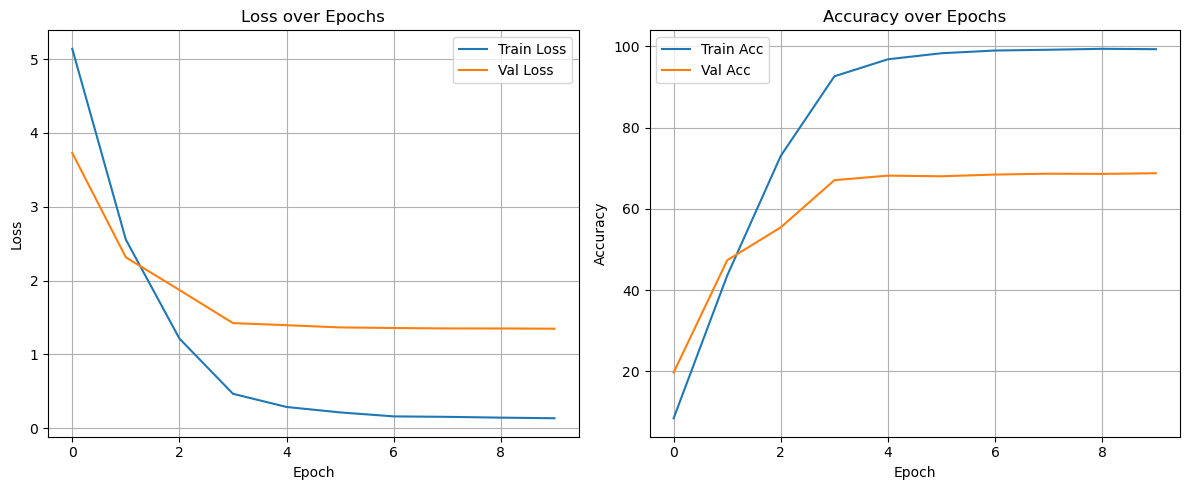

In [ ]:
# Визуализация обучения

epochs = range(num_epochs)
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Test Accuracy, efficientnetb1 с CE Loss: 70.11%

### Этап 5: Подготовка модели и ArcFaceLoss

In [ ]:
# ArcFaceLoss

class ArcFaceLogits(nn.Module):
    def __init__(self, ebmb_size, n_classes):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(ebmb_size, n_classes)).to(device)
        nn.init.xavier_uniform_(self.weights)
        
    def forward(self, embeddings):
        # L2-нормализация эмбеддингов
        embeddings = F.normalize(embeddings, dim=1)
        
        # L2-нормализация весов (по столбцам)
        weights = F.normalize(self.weights, dim=0)
        
        # вычисление cosθ между эмбеддингами и классами
        logits = embeddings @ weights
        return logits


class ArcFaceLoss(nn.Module):
    def __init__(self, n_classes, s=50.0, m=0.5):
        super().__init__()
        self.s = s # Scale factor
        self.m = m # Additive angular margin penalty
        self.n_classes = n_classes

    def forward(self, logits, labels):
        # защита от NaN
        cosine = logits.clip(-1 + 1e-7, 1 - 1e-7)  
        
        # преобразование cos в угол θ
        theta = torch.acos(cosine)  
        
        # Сдвиг угла на m (additive angular margin penalty)
        theta += F.one_hot(labels, self.n_classes) * self.m 
        
        # масштабирование на s
        cosine_s = theta.cos() * self.s 
        
        # финальный softmax loss
        return F.cross_entropy(cosine_s, labels)

In [8]:
# Модифицируем модель для ArcFace - удаляем classifier head
# Без него ArcFaceEfficientNet не подходит для предсказания классов — только для эмбеддингов

class ArcFaceEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Загружаем предобученную модель efficientnet_b1, weights: IMAGENET1K_V2
        self.net = models.efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
        
        # Извлечем информацию о размере эмбеддинга
        self.emb_size = self.net.classifier[1].in_features
        
        # Убираем классификационную голову оригинального EfficientNet
        # получаем все слои, кроме classifier
        # остаётся backbone EfficientNet + слой pooling → выход: [batch_size, emb_size]
        self.net = nn.Sequential(*list(self.net.children())[:-1])
        
    def forward(self, x):
        # Вектор размера [batch_size, emb_size] - именно эмбеддинг лица
        return self.net(x).squeeze() 

In [ ]:
# Функция обучения модели с ArcFaceLoss

def train_model_arcface(
    model, 
    logits_calc,
    train_loader,
    val_loader,
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=30, 
    patience=3, 
    checkpoint_path='./', 
    model_name="", 
    device='cuda'
    ):
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Early stopping
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            features = model(images)
            logits = logits_calc(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Оценка на валидации
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                features = model(images)
                logits = logits_calc(features)
                loss = criterion(logits, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(100 * val_correct / val_total)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # Save model checkpoint
            torch.save(model.state_dict(), checkpoint_path + f"{model_name}_{epoch + 1}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
    return train_losses, train_accuracies, val_losses, val_accuracies

### Этап 6: Обучение модели с лосс - ArcFaceLoss

In [ ]:
# Обучение модели с ArcFaceLoss

batch_size = 64
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, num_workers=0, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=batch_size, shuffle=False)

model_arc = ArcFaceEfficientNet() 
ebmb_size = model_arc.emb_size
print(f"ebmbedding size: {ebmb_size}")
n_classes = len(np.unique(images_info.image_id))
print(f"{n_classes} classes")
print(f"device: {device}")
model_arc.to(device)

logits_calc = ArcFaceLogits(ebmb_size, n_classes)
criterion = ArcFaceLoss(n_classes)
optimizer = optim.Adam(model_arc.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_losses, train_accuracies, val_losses, val_accuracies = train_model_arcface(
    model_arc,
    logits_calc,
    train_loader,
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=30,
    model_name="ArcFaceEfficientNet_b1",
    device=device
)

# torch.cuda.empty_cache()

ebmbedding size: 1280
500 classes
device: cuda


Epoch 1/30: 100%|█████████████████████████████████████████████████| 134/134 [01:36<00:00,  1.38it/s]


Train Loss: 30.2219, Accuracy: 3.34%
Validation Loss: 29.1284, Validation Accuracy: 10.11%


Epoch 2/30: 100%|█████████████████████████████████████████████████| 134/134 [01:31<00:00,  1.46it/s]


Train Loss: 28.1291, Accuracy: 24.13%
Validation Loss: 28.0075, Validation Accuracy: 26.06%


Epoch 3/30: 100%|█████████████████████████████████████████████████| 134/134 [01:38<00:00,  1.37it/s]


Train Loss: 26.1424, Accuracy: 52.07%
Validation Loss: 26.3711, Validation Accuracy: 43.35%


Epoch 4/30: 100%|█████████████████████████████████████████████████| 134/134 [01:27<00:00,  1.54it/s]


Train Loss: 23.8255, Accuracy: 72.66%
Validation Loss: 24.7752, Validation Accuracy: 55.59%


Epoch 5/30: 100%|█████████████████████████████████████████████████| 134/134 [01:27<00:00,  1.53it/s]


Train Loss: 21.3612, Accuracy: 82.70%
Validation Loss: 23.2336, Validation Accuracy: 61.44%


Epoch 6/30: 100%|█████████████████████████████████████████████████| 134/134 [01:32<00:00,  1.45it/s]


Train Loss: 18.6219, Accuracy: 89.64%
Validation Loss: 20.9347, Validation Accuracy: 67.82%


Epoch 7/30: 100%|█████████████████████████████████████████████████| 134/134 [01:37<00:00,  1.37it/s]


Train Loss: 15.7961, Accuracy: 92.61%
Validation Loss: 18.9360, Validation Accuracy: 71.81%


Epoch 8/30: 100%|█████████████████████████████████████████████████| 134/134 [01:36<00:00,  1.39it/s]


Train Loss: 13.3066, Accuracy: 94.60%
Validation Loss: 17.4675, Validation Accuracy: 71.54%


Epoch 9/30: 100%|█████████████████████████████████████████████████| 134/134 [01:31<00:00,  1.46it/s]


Train Loss: 10.8041, Accuracy: 96.20%
Validation Loss: 14.2336, Validation Accuracy: 80.85%


Epoch 10/30: 100%|████████████████████████████████████████████████| 134/134 [01:35<00:00,  1.40it/s]


Train Loss: 8.8309, Accuracy: 97.33%
Validation Loss: 13.5963, Validation Accuracy: 80.05%


Epoch 11/30: 100%|████████████████████████████████████████████████| 134/134 [01:33<00:00,  1.44it/s]


Train Loss: 7.1587, Accuracy: 97.93%
Validation Loss: 12.4197, Validation Accuracy: 80.32%


Epoch 12/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.42it/s]


Train Loss: 5.9115, Accuracy: 98.49%
Validation Loss: 10.9594, Validation Accuracy: 81.38%


Epoch 13/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.41it/s]


Train Loss: 4.9938, Accuracy: 98.74%
Validation Loss: 11.4411, Validation Accuracy: 81.12%


Epoch 14/30: 100%|████████████████████████████████████████████████| 134/134 [01:35<00:00,  1.40it/s]


Train Loss: 4.2555, Accuracy: 99.09%
Validation Loss: 11.0666, Validation Accuracy: 82.18%


Epoch 15/30: 100%|████████████████████████████████████████████████| 134/134 [01:36<00:00,  1.38it/s]


Train Loss: 3.6998, Accuracy: 99.33%
Validation Loss: 9.9731, Validation Accuracy: 81.65%


Epoch 16/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.41it/s]


Train Loss: 3.1455, Accuracy: 99.51%
Validation Loss: 11.1373, Validation Accuracy: 80.05%


Epoch 17/30: 100%|████████████████████████████████████████████████| 134/134 [01:41<00:00,  1.32it/s]


Train Loss: 2.9529, Accuracy: 99.66%
Validation Loss: 10.1163, Validation Accuracy: 81.38%


Epoch 18/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.42it/s]


Train Loss: 2.8717, Accuracy: 99.59%
Validation Loss: 11.0730, Validation Accuracy: 81.12%


Epoch 19/30: 100%|████████████████████████████████████████████████| 134/134 [01:32<00:00,  1.45it/s]


Train Loss: 2.1518, Accuracy: 99.84%
Validation Loss: 8.0786, Validation Accuracy: 86.17%


Epoch 20/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.42it/s]


Train Loss: 1.7097, Accuracy: 99.89%
Validation Loss: 7.7933, Validation Accuracy: 85.90%


Epoch 21/30: 100%|████████████████████████████████████████████████| 134/134 [01:33<00:00,  1.43it/s]


Train Loss: 1.5520, Accuracy: 99.95%
Validation Loss: 7.8024, Validation Accuracy: 85.64%


Epoch 22/30: 100%|████████████████████████████████████████████████| 134/134 [01:32<00:00,  1.44it/s]


Train Loss: 1.4198, Accuracy: 99.95%
Validation Loss: 7.5546, Validation Accuracy: 87.50%


Epoch 23/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.41it/s]


Train Loss: 1.2310, Accuracy: 99.98%
Validation Loss: 7.5765, Validation Accuracy: 87.50%


Epoch 24/30: 100%|████████████████████████████████████████████████| 134/134 [01:33<00:00,  1.44it/s]


Train Loss: 1.1815, Accuracy: 99.95%
Validation Loss: 7.4167, Validation Accuracy: 88.03%


Epoch 25/30: 100%|████████████████████████████████████████████████| 134/134 [01:33<00:00,  1.44it/s]


Train Loss: 1.1337, Accuracy: 99.96%
Validation Loss: 7.5280, Validation Accuracy: 87.23%


Epoch 26/30: 100%|████████████████████████████████████████████████| 134/134 [01:31<00:00,  1.46it/s]


Train Loss: 1.0550, Accuracy: 99.98%
Validation Loss: 7.5635, Validation Accuracy: 87.50%


Epoch 27/30: 100%|████████████████████████████████████████████████| 134/134 [01:37<00:00,  1.38it/s]


Train Loss: 0.8717, Accuracy: 99.95%
Validation Loss: 7.7812, Validation Accuracy: 85.64%


Epoch 28/30: 100%|████████████████████████████████████████████████| 134/134 [01:32<00:00,  1.45it/s]


Train Loss: 0.8170, Accuracy: 99.98%
Validation Loss: 7.1533, Validation Accuracy: 86.44%


Epoch 29/30: 100%|████████████████████████████████████████████████| 134/134 [01:34<00:00,  1.42it/s]


Train Loss: 0.7746, Accuracy: 99.98%
Validation Loss: 7.2671, Validation Accuracy: 86.44%


Epoch 30/30: 100%|████████████████████████████████████████████████| 134/134 [01:31<00:00,  1.46it/s]


Train Loss: 0.6745, Accuracy: 99.98%
Validation Loss: 7.2450, Validation Accuracy: 86.70%


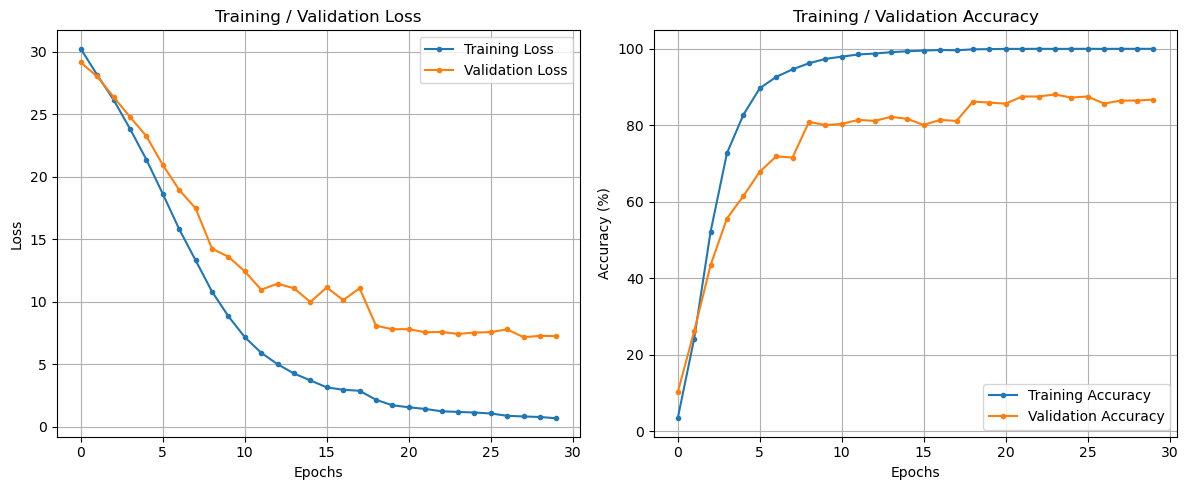

In [ ]:
# Визуализация обучения

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='.')
plt.plot(val_losses, label='Validation Loss', marker='.')
plt.title('Training / Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='.')
plt.plot(val_accuracies, label='Validation Accuracy', marker='.')
plt.title('Training / Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Проверка на тестовых данных

model_arc.eval()
test_running_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test', unit='batch'):        
        images, labels = images.to(device), labels.to(device)
        features = model_arc(images)
        logits = logits_calc(features)
        loss = criterion(logits, labels).mean()
        test_running_loss += loss.item()

        _, predicted = torch.max(logits.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test: 100%|██████████| 25/25 [00:15<00:00,  1.58batch/s]

Test Loss: 6.8144, Test Accuracy: 87.79%


### Test Accuracy, efficientnetb1 с ArcFace Loss: 87.79%

Модель с ArcFace Loss лучше по точности чем с кроссэнтропией. И это правильно.
Для хорошего результата нужно применять методы уменьшения LR, например ReduceLROnPlateau / StepLR.

### 7. Вычисление эмбеддингов изображений:

In [ ]:
# Функция для вычисления эмбеддингов изображений

def compute_embeddings(model, images_list, device='cuda', rescale_size=256):
    model = model.to(device).eval()
    embeddings = []

    transform = transforms.Compose([
        transforms.Resize((rescale_size, rescale_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for img_path in images_list:
            img = Image.open(img_path).convert('RGB')
            x = transform(img).unsqueeze(0).to(device)  # [1,3,H,W]
            out = model(x)  # ожидаемый выход [1, emb_size]
            
            # Если прям вырезаем последний слой:
            if out.dim() == 1:
                out = out.unsqueeze(0)  # сделает [1, emb_size]

            out = F.normalize(out, p=2, dim=1)
            embeddings.append(out.cpu().numpy())

    embeddings = np.vstack(embeddings)  # (N, emb_size)
    return embeddings

In [ ]:
# Сравнение эмбеддингов:
# Загрузить аннотации (идентификаторы лиц) из celebA_anno.txt.
# Выбрать по 10 изображений той же личности и по 10 — разных.
# Применить compute_embeddings() и посчитать косинусную схожесть.


# Загрузка аннотаций
# читаем фиксации путей и identity-label
def load_annotations(annotations_file):
    id_dict = {}  # mapping image_name -> identity
    with open(annotations_file, 'r') as f:
        for line in f:
            name, identity = line.strip().split()
            id_dict[name] = int(identity)
    return id_dict


# Выбор изображений
def sample_same_and_diff(id_dict, images_dir, same_identity, n=10):
    # собираем всех по одному id
    same = [name for name, pid in id_dict.items() if pid == same_identity]
    if len(same) < n: raise ValueError
    same = random.sample(same, n)
    
    diff = [name for name, pid in id_dict.items() if pid != same_identity]
    diff = random.sample(diff, n)
    
    return [os.path.join(images_dir, name) for name in same], \
           [os.path.join(images_dir, name) for name in diff]
           

# Загрузка модели
model = ArcFaceEfficientNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка весов модели
weights_path = "ArcFaceEfficientNet_b1_24_valacc88.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict)
print("Weights successfully loaded!")

Weights successfully loaded!


C:\Users\Ritz\AppData\Local\Temp\ipykernel_27112\1868701852.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.dev

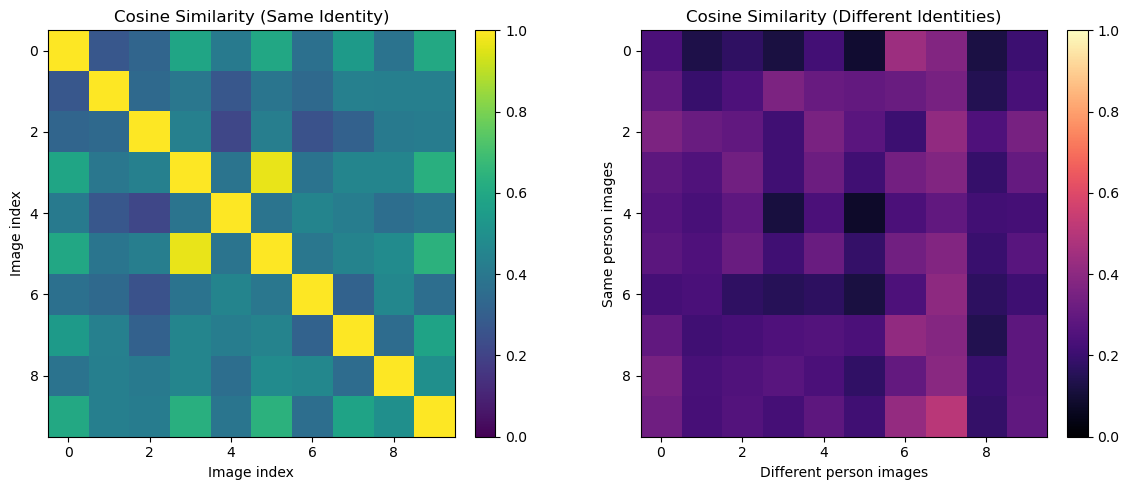

In [ ]:
# Сравнение эмбеддингов

images_dir = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_imgs'
annotations_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_anno.txt'
split_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA_train_500/celebA_train_split.txt'

id_map = load_annotations(annotations_file)

# берем identity первого изображения как пример
first_img = next(iter(id_map))
same_id = id_map[first_img]

same_list, diff_list = sample_same_and_diff(id_map, images_dir, same_id, n=10)

emb_same = compute_embeddings(model, same_list, device=device, rescale_size=256)
emb_diff = compute_embeddings(model, diff_list, device=device, rescale_size=256)

# матрица попарных cosines 
sim_same = cosine_similarity(emb_same)
sim_diff = cosine_similarity(emb_same, emb_diff)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Матрица "same"
ax = axes[0]
im = ax.imshow(sim_same, vmin=0, vmax=1, cmap='viridis')
ax.set_title('Cosine Similarity (Same Identity)')
ax.set_xlabel('Image index')
ax.set_ylabel('Image index')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Матрица "diff"
ax = axes[1]
im = ax.imshow(sim_diff, vmin=0, vmax=1, cmap='magma')
ax.set_title('Cosine Similarity (Different Identities)')
ax.set_xlabel('Different person images')
ax.set_ylabel('Same person images')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


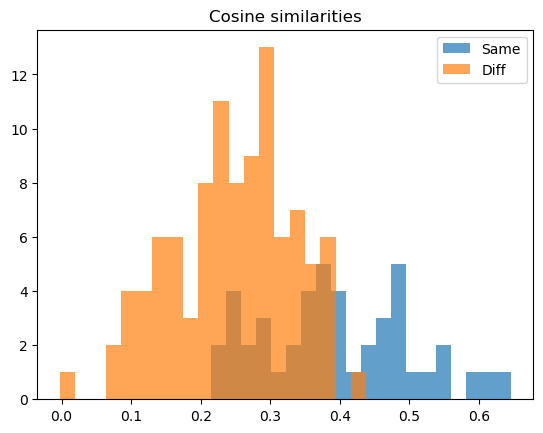

In [ ]:
# Визуализация распределений попарных cosines 10 картинок одного человека и разных людей.

same_vals = sim_same[np.triu_indices(10, k=1)]
diff_vals = sim_diff.flatten()

plt.hist(same_vals, bins=20, alpha=0.7, label='Same')
plt.hist(diff_vals, bins=20, alpha=0.7, label='Diff')
plt.legend()
plt.title("Cosine similarities")
plt.show()

Видно, что cosine_similarity для разных фото одного человека начинаются с 0,2, и пересекаются с cosine_similarity для разных людей.

Test Accuracy с ArcFace Loss 87.8% значительно превышает Accuracy с CrossEntropy (70%). Но даже с ArcFace Loss эмбеддинги для лиц одинаковых персонажей сильно пересекаются с эмбеддингами для лиц различных людей.